# Fantasy Football Draft Quantitative Analysis

By Sam Hughes

## Overview

**Fantasy Football Explanation**

Fantasy Football is a game based upon 
real football players' statistical performances. 
A fantasy football owner scores fantasy points 
when NFL players score touchdowns, 
gain yardage, catch passes, etc. 

To determine the initial rosters of fantasy teams, 
there is a fantasy draft among leaguemates at the start of the year. 

After drafting a fantasy team, leaguemates compete 
against each other until the end of the NFL 
regular season. 

**Motivation**

According to ESPN, forty million people play 
fantasy football in the United States. 
Anyone who plays fantasy football and wants 
to win should be interested in optimizing their 
drafting strategy.

**Data**

All the data I used was found on either ESPN or FantasyPros, 
which are two of the most popular sites for fantasy football. 

Important variables used include:
- ADP: The average pick used to select a player in a fantasy draft. 
For example, more desirable players will have an ADP near 1. 
- Ranking: The suggested order fantasy players should be picked. 
Rankings are made by ESPN and FantasyPros. 
- Average Score: The average fantasy points a player scores per week. 

**Methods**

I used two types of models, and compared their performances.
- GAM: Great for continuous data
- XGBoost: Very powerful, tree based modeling

**Existing Works**

I was unable to find any existing works of using fantasy rankings 
and ADP to predict the weekly scoring total. 

In [1]:
from traitlets.config.manager import BaseJSONConfigManager
from pathlib import Path
path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
cm.update(
    "rise",
    {
        "scroll": True,
        "transition": "slide",
     }
)

{'scroll': True, 'transition': 'slide'}

## Data Setup

**ADP Data**

In [2]:
import pandas as pd

In [3]:
df_ADP = pd.read_html("https://www.fantasypros.com/nfl/adp/ppr-overall.php?year=2015")[0]
df_ADP["year"] = int(2015)
df_ADP.head()

,Rank,Player Team (Bye),POS,ESPN,RTSports,MFL,Fantrax,FFC,Sleeper,AVG,year
0,1,Le'Veon Bell,RB1,NaN,1.0,1.0,1.0,3.0,NaN,1.5,2015
1,2,Adrian Peterson SEA (9),RB2,NaN,2.0,2.0,2.0,1.0,NaN,1.8,2015
2,3,Antonio Brown,WR1,NaN,4.0,5.0,4.0,2.0,NaN,3.8,2015
3,4,Jamaal Charles,RB3,NaN,5.0,3.0,3.0,5.0,NaN,4.0,2015
4,5,Eddie Lacy,RB4,NaN,3.0,4.0,5.0,4.0,NaN,4.0,2015


In [4]:
for i in range(16, 22):
    df_ADP = df_ADP.append(pd.read_html(
        "https://www.fantasypros.com/nfl/adp/ppr-overall.php?year=20" + str(i))[0])
    
    df_ADP.loc[df_ADP["year"].isnull(), "year"] = int("20" + str(i))
df_ADP.reset_index(drop = True, inplace = True)
df_ADP.sample(10)

,Rank,Player Team (Bye),POS,ESPN,RTSports,MFL,Fantrax,FFC,Sleeper,AVG,year
633,173,Kenneth Dixon,RB57,NaN,NaN,185.0,232.0,169.0,NaN,185.5,2016.0
2807,899,Daniel Lasco,RB244,790.0,NaN,NaN,NaN,NaN,NaN,790.0,2019.0
1144,133,Austin Hooper TEN (8),TE15,159.0,NaN,135.0,150.0,133.0,NaN,145.0,2017.0
2657,749,Nick Bawden NYJ (4) O,RB203,625.0,NaN,NaN,NaN,NaN,NaN,625.0,2019.0
1350,339,Washington Commanders DST (5),DST29,NaN,NaN,280.0,NaN,NaN,NaN,280.0,2017.0
1695,275,Dallas Cowboys DST (8),DST20,NaN,257.0,243.0,NaN,NaN,NaN,250.0,2018.0
2197,289,Marshawn Lynch,RB74,235.0,NaN,NaN,387.0,NaN,NaN,292.0,2019.0
2664,756,Derrick Willies,WR241,633.0,NaN,NaN,NaN,NaN,NaN,633.0,2019.0
2179,271,Josh Lambo,K23,282.0,NaN,262.0,375.0,NaN,NaN,292.5,2019.0
3367,412,Marcus Mariota ATL (10),QB54,NaN,NaN,NaN,327.0,NaN,NaN,327.0,2020.0


Clean column names

In [5]:
df_ADP.rename({
               "Rank": "rank_adp", 
               "Player Team (Bye)": "player", 
               "AVG": "avg_adp"
              }, axis = 1, inplace = True)
df_ADP.columns = df_ADP.columns.str.lower()
df_ADP.head()

,rank_adp,player,pos,espn,rtsports,mfl,fantrax,ffc,sleeper,avg_adp,year
0,1,Le'Veon Bell,RB1,NaN,1.0,1.0,1.0,3.0,NaN,1.5,2015.0
1,2,Adrian Peterson SEA (9),RB2,NaN,2.0,2.0,2.0,1.0,NaN,1.8,2015.0
2,3,Antonio Brown,WR1,NaN,4.0,5.0,4.0,2.0,NaN,3.8,2015.0
3,4,Jamaal Charles,RB3,NaN,5.0,3.0,3.0,5.0,NaN,4.0,2015.0
4,5,Eddie Lacy,RB4,NaN,3.0,4.0,5.0,4.0,NaN,4.0,2015.0


Clean position (because position includes ranking number)

In [6]:
df_ADP['pos'] = df_ADP['pos'].str.replace('\d+', '')
df_ADP.head()

C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/2860961360.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_ADP['pos'] = df_ADP['pos'].str.replace('\d+', '')


,rank_adp,player,pos,espn,rtsports,mfl,fantrax,ffc,sleeper,avg_adp,year
0,1,Le'Veon Bell,RB,NaN,1.0,1.0,1.0,3.0,NaN,1.5,2015.0
1,2,Adrian Peterson SEA (9),RB,NaN,2.0,2.0,2.0,1.0,NaN,1.8,2015.0
2,3,Antonio Brown,WR,NaN,4.0,5.0,4.0,2.0,NaN,3.8,2015.0
3,4,Jamaal Charles,RB,NaN,5.0,3.0,3.0,5.0,NaN,4.0,2015.0
4,5,Eddie Lacy,RB,NaN,3.0,4.0,5.0,4.0,NaN,4.0,2015.0


Clean player names (because player names include team and bye)

In [7]:
df_ADP.loc[df_ADP["pos"] == "DST", "player"] = [i[0] for i in 
                                                df_ADP.loc[df_ADP["pos"] == "DST", 
                                                           "player"].str.split(" DST")]
df_ADP.loc[df_ADP["pos"] == "DST", "player"]

temp = df_ADP.loc[df_ADP["pos"] != "DST", "player"].str.split(n = 2)
df_ADP.loc[df_ADP["pos"] != "DST", "player"] = temp.str[0] + " " + temp.str[1]
df_ADP.head()

,rank_adp,player,pos,espn,rtsports,mfl,fantrax,ffc,sleeper,avg_adp,year
0,1,Le'Veon Bell,RB,NaN,1.0,1.0,1.0,3.0,NaN,1.5,2015.0
1,2,Adrian Peterson,RB,NaN,2.0,2.0,2.0,1.0,NaN,1.8,2015.0
2,3,Antonio Brown,WR,NaN,4.0,5.0,4.0,2.0,NaN,3.8,2015.0
3,4,Jamaal Charles,RB,NaN,5.0,3.0,3.0,5.0,NaN,4.0,2015.0
4,5,Eddie Lacy,RB,NaN,3.0,4.0,5.0,4.0,NaN,4.0,2015.0


**Fantasy Points Data**

In [8]:
df_points = pd.read_html(
    "https://www.fantasypros.com/nfl/reports/leaders/ppr.php?year=2015&start=1&end=16")[0]
df_points["year"] = 2015
df_points.head()

,Rank,Player,Team,Position,Points,Games,Avg,year
0,1.0,Cam Newton,CAR,QB,356.4,15.0,23.8,2015
1,2.0,Julio Jones,ATL,WR,351.2,15.0,23.4,2015
2,3.0,Antonio Brown,PIT,WR,346.5,15.0,23.1,2015
3,4.0,Tom Brady,NE,QB,339.4,15.0,22.6,2015
4,5.0,Russell Wilson,SEA,QB,315.2,15.0,21.0,2015


In [9]:
for i in range(16, 22):
    df_points = df_points.append(
        pd.read_html(
            ("https://www.fantasypros.com/nfl/reports/leaders/ppr.php?year=20" 
             + str(i) + "&start=1&end=16")
                    )[0])
    df_points.loc[df_points["year"].isnull(), "year"] = int("20" + str(i))
    
df_points.reset_index(drop = True, inplace = True)
df_points.sample(10)

,Rank,Player,Team,Position,Points,Games,Avg,year
4027,636.0,Jordan Matthews,SF,WR,0.0,1.0,0.0,2020.0
2005,89.0,Sam Darnold,NYJ,QB,160.9,12.0,13.4,2018.0
3437,62.0,Curtis Samuel,CAR,WR,193.0,14.0,13.8,2020.0
3669,294.0,Tennessee Titans,TEN,DST,64.0,15.0,4.3,2020.0
1627,349.0,De'Anthony Thomas,KC,WR,40.7,13.0,3.1,2017.0
915,260.0,Greg Zuerlein,LAR,K,81.0,14.0,5.8,2016.0
562,560.0,Rod Smith,Multi,RB,2.1,4.0,0.5,2015.0
2133,217.0,Chris Boswell,PIT,K,93.1,15.0,6.2,2018.0
3882,507.0,Kai Forbath,LAR,K,10.0,2.0,5.0,2020.0
1553,275.0,Corey Davis,TEN,WR,69.5,10.0,7.0,2017.0


In [10]:
df_points.rename({
                  "Rank": "rank_scoring", 
                  "Position": "pos", 
                  "Avg": "avg_scoring"
                 }, axis = 1, inplace = True)
df_points.columns = df_points.columns.str.lower()
df_points.head()

,rank_scoring,player,team,pos,points,games,avg_scoring,year
0,1.0,Cam Newton,CAR,QB,356.4,15.0,23.8,2015.0
1,2.0,Julio Jones,ATL,WR,351.2,15.0,23.4,2015.0
2,3.0,Antonio Brown,PIT,WR,346.5,15.0,23.1,2015.0
3,4.0,Tom Brady,NE,QB,339.4,15.0,22.6,2015.0
4,5.0,Russell Wilson,SEA,QB,315.2,15.0,21.0,2015.0


In [11]:
temp = df_points.loc[df_points["pos"] != "DST", "player"].str.split(n = 2)
df_points.loc[df_points["pos"] != "DST", "player"] = temp.str[0] + " " + temp.str[1]
df_points.head()

,rank_scoring,player,team,pos,points,games,avg_scoring,year
0,1.0,Cam Newton,CAR,QB,356.4,15.0,23.8,2015.0
1,2.0,Julio Jones,ATL,WR,351.2,15.0,23.4,2015.0
2,3.0,Antonio Brown,PIT,WR,346.5,15.0,23.1,2015.0
3,4.0,Tom Brady,NE,QB,339.4,15.0,22.6,2015.0
4,5.0,Russell Wilson,SEA,QB,315.2,15.0,21.0,2015.0


Merge dataframes

In [12]:
df = pd.merge(df_ADP, df_points,  how='left', on = ["player", "pos", "year"])
df.head()

,rank_adp,player,pos,espn,rtsports,mfl,fantrax,ffc,sleeper,avg_adp,year,rank_scoring,team,points,games,avg_scoring
0,1,Le'Veon Bell,RB,NaN,1.0,1.0,1.0,3.0,NaN,1.5,2015.0,186.0,PIT,111.2,6.0,18.5
1,2,Adrian Peterson,RB,NaN,2.0,2.0,2.0,1.0,NaN,1.8,2015.0,29.0,MIN,246.9,15.0,16.5
2,3,Antonio Brown,WR,NaN,4.0,5.0,4.0,2.0,NaN,3.8,2015.0,3.0,PIT,346.5,15.0,23.1
3,4,Jamaal Charles,RB,NaN,5.0,3.0,3.0,5.0,NaN,4.0,2015.0,213.0,KC,101.1,5.0,20.2
4,5,Eddie Lacy,RB,NaN,3.0,4.0,5.0,4.0,NaN,4.0,2015.0,135.0,GB,134.5,14.0,9.6


Make defense names the team abbreviation for consistency with future merges

In [13]:
df.loc[df["pos"] == "DST", "player"] = df.loc[df["pos"] == "DST", "team"]
df.sample(5)

,rank_adp,player,pos,espn,rtsports,mfl,fantrax,ffc,sleeper,avg_adp,year,rank_scoring,team,points,games,avg_scoring
134,135,Joe Flacco,QB,NaN,144.0,146.0,129.0,153.0,NaN,143.0,2015.0,95.0,BAL,162.1,10.0,16.2
1516,96,Randall Cobb,WR,101.0,103.0,108.0,91.0,94.0,NaN,99.4,2018.0,247.0,GB,82.7,8.0,10.3
1822,402,Akeem Hunt,RB,NaN,NaN,NaN,352.0,NaN,NaN,352.0,2018.0,NaN,NaN,NaN,NaN,NaN
1912,4,Ezekiel Elliott,RB,4.0,4.0,4.0,4.0,4.0,NaN,4.0,2019.0,12.0,DAL,284.3,15.0,19.0
3357,402,Sam Bradford,QB,320.0,NaN,NaN,NaN,NaN,NaN,320.0,2020.0,NaN,NaN,NaN,NaN,NaN


**ESPN Rankings**

In [14]:
df_espn = pd.read_csv("espn/2015.csv")
df_espn["year"] = 2015
df_espn.head()

,rank,pos,first,last,team,bye,year
0,1,(RB1),Le'Veon,Bell,PIT,11,2015
1,2,(RB2),Adrian,Peterson,MIN,5,2015
2,3,(RB3),Jamaal,Charles,KC,9,2015
3,4,(RB4),Eddie,Lacy,GB,7,2015
4,5,(RB5),Marshawn,Lynch,SEA,9,2015


In [15]:
for i in range(16, 22):
    # for some reason, ESPN does not have public rankings available for 2019
    if i == 19:
        continue
    df_espn = df_espn.append(pd.read_csv("espn/20" + str(i) + ".csv"))
    df_espn.loc[df_espn["year"].isnull(), "year"] = int("20" + str(i))

df_espn.reset_index(drop = True, inplace = True)
df_espn.sample(5)

,rank,pos,first,last,team,bye,year
1533,34,(WR14),Mike,Evans,TB,9.0,2021.0
1252,53,(WR24),Jarvis,Landry,CLE,9,2020.0
302,3,(WR3),Odell,Beckham Jr.,NYG,8,2016.0
981,82,(WR38),Cooper,Kupp,LAR,12,2018.0
476,177,(RB59),DeAndre,Washington,OAK,10,2016.0


In [16]:
df_espn.rename({
                  "rank": "rank_espn", 
                 }, axis = 1, inplace = True)
df_espn.head()

,rank_espn,pos,first,last,team,bye,year
0,1,(RB1),Le'Veon,Bell,PIT,11,2015.0
1,2,(RB2),Adrian,Peterson,MIN,5,2015.0
2,3,(RB3),Jamaal,Charles,KC,9,2015.0
3,4,(RB4),Eddie,Lacy,GB,7,2015.0
4,5,(RB5),Marshawn,Lynch,SEA,9,2015.0


In [17]:
%%capture --no-display

df_espn['pos'] = df_espn['pos'].str.replace('\d+', '')
df_espn['pos'] = df_espn['pos'].str.replace('(', '')
df_espn['pos'] = df_espn['pos'].str.replace(')', '')
df_espn.head()

,rank_espn,pos,first,last,team,bye,year
0,1,RB,Le'Veon,Bell,PIT,11,2015.0
1,2,RB,Adrian,Peterson,MIN,5,2015.0
2,3,RB,Jamaal,Charles,KC,9,2015.0
3,4,RB,Eddie,Lacy,GB,7,2015.0
4,5,RB,Marshawn,Lynch,SEA,9,2015.0


In [18]:
df_espn.loc[df_espn["team"] == "CLE$0", "team"] = "CLE"

In [19]:
df_espn["player"] = df_espn["first"] + " " + df_espn["last"]
df_espn.drop(["first", "last"], axis = 1, inplace = True)

In [20]:
temp = df_espn.loc[df_espn["pos"] != "DST", "player"].str.split(n = 2)
df_espn.loc[df_espn["pos"] != "DST", "player"] = temp.str[0] + " " + temp.str[1]
df_espn.head()

,rank_espn,pos,team,bye,year,player
0,1,RB,PIT,11,2015.0,Le'Veon Bell
1,2,RB,MIN,5,2015.0,Adrian Peterson
2,3,RB,KC,9,2015.0,Jamaal Charles
3,4,RB,GB,7,2015.0,Eddie Lacy
4,5,RB,SEA,9,2015.0,Marshawn Lynch


In [21]:
df_espn.loc[df_espn["pos"] == "DST", "player"] = df_espn.loc[df_espn["pos"] == "DST", "team"]
df_espn.sample(5)

,rank_espn,pos,team,bye,year,player
377,78,QB,NE,9,2016.0,Tom Brady
1717,218,WR,SEA,9.0,2021.0,D'Wayne Eskridge
608,9,RB,BUF,6,2017.0,LeSean McCoy
534,235,RB,BUF,10,2016.0,Mike Gillislee
516,217,WR,SF,8,2016.0,Quinton Patton


Merge new dataframe with previous dataframes

In [22]:
df = pd.merge(df, df_espn,  how='left', on = ["player", "pos", "year"])
df.head()

,rank_adp,player,pos,espn,rtsports,mfl,fantrax,ffc,sleeper,avg_adp,year,rank_scoring,team_x,points,games,avg_scoring,rank_espn,team_y,bye
0,1,Le'Veon Bell,RB,NaN,1.0,1.0,1.0,3.0,NaN,1.5,2015.0,186.0,PIT,111.2,6.0,18.5,1.0,PIT,11
1,2,Adrian Peterson,RB,NaN,2.0,2.0,2.0,1.0,NaN,1.8,2015.0,29.0,MIN,246.9,15.0,16.5,2.0,MIN,5
2,3,Antonio Brown,WR,NaN,4.0,5.0,4.0,2.0,NaN,3.8,2015.0,3.0,PIT,346.5,15.0,23.1,6.0,PIT,11
3,4,Jamaal Charles,RB,NaN,5.0,3.0,3.0,5.0,NaN,4.0,2015.0,213.0,KC,101.1,5.0,20.2,3.0,KC,9
4,5,Eddie Lacy,RB,NaN,3.0,4.0,5.0,4.0,NaN,4.0,2015.0,135.0,GB,134.5,14.0,9.6,4.0,GB,7


**FantasyPros Rankings**

In [23]:
df_fp = pd.read_csv("fantasypros/FantasyPros_2015_Draft_ALL_Rankings.csv")
df_fp["year"] = 2015
df_fp

,RK,TIERS,PLAYER NAME,TEAM,POS,BEST,WORST,AVG.,STD.DEV,year
0,1,1,Le'Veon Bell,FA,RB1,1,10,2.3,1.9,2015
1,2,1,Jamaal Charles,FA,RB2,1,15,4.3,3.1,2015
2,3,1,Adrian Peterson,SEA,RB3,1,14,4.5,3.8,2015
3,4,1,Antonio Brown,FA,WR1,1,13,4.5,2.3,2015
4,5,1,Eddie Lacy,FA,RB4,1,15,5.3,3.2,2015
...,...,...,...,...,...,...,...,...,...,...
361,362,15,Bruce Ellington,FA,WR119,209,429,319.0,110.0,2015
362,363,15,Lance Kendricks,FA,TE48,219,276,247.5,28.5,2015
363,364,15,Johnny Manziel,FA,QB34,231,440,335.5,104.5,2015
364,365,15,Ryan Mallett,FA,QB35,233,443,338.0,105.0,2015


In [24]:
for i in range(16, 22):
    df_fp = df_fp.append(pd.read_csv("fantasypros/FantasyPros_20" + str(i) + "_Draft_ALL_Rankings.csv"))
    df_fp.loc[df_fp["year"].isnull(), "year"] = int("20" + str(i))

df_fp.reset_index(drop = True, inplace = True)
df_fp.sample(10)

,RK,TIERS,PLAYER NAME,TEAM,POS,BEST,WORST,AVG.,STD.DEV,year,BYE WEEK,SOS SEASON,ECR VS. ADP
230,231,12,Nick Foles,CHI,QB27,150.0,244.0,184.2,22.3,2015.0,NaN,NaN,NaN
2119,451,15,Detrez Newsome,FA,RB137,256.0,388.0,334.4,51.5,2019.0,NaN,NaN,NaN
1965,297,12,Preston Williams,MIA,WR103,133.0,374.0,248.8,58.5,2019.0,NaN,NaN,NaN
1573,426,14,Ryan Grant,FA,RB117,198.0,249.0,223.5,25.5,2018.0,NaN,NaN,NaN
2202,534,16,DeAndre Carter,LAC,WR170,315.0,396.0,355.5,40.5,2019.0,NaN,NaN,NaN
2227,13,3,DeAndre Hopkins,ARI,WR5,9.0,48.0,15.8,6.1,2020.0,NaN,NaN,NaN
642,277,14,DeAndre Smelter,FA,WR104,177.0,248.0,207.4,22.6,2016.0,NaN,NaN,NaN
3232,480,13,Ross Dwelley,SF,TE70,NaN,NaN,NaN,NaN,2021.0,6,4 out of 5 stars,-
1886,218,11,Seattle Seahawks,SEA,DST15,160.0,313.0,215.2,29.7,2019.0,NaN,NaN,NaN
2828,76,6,Brandin Cooks,HOU,WR34,NaN,NaN,NaN,NaN,2021.0,10,3 out of 5 stars,-


In [25]:
df_fp.drop(["TIERS", "BEST", "WORST", "STD.DEV", "BYE WEEK", "SOS SEASON", "ECR VS. ADP"], axis = 1, inplace = True)
df_fp.head()

,RK,PLAYER NAME,TEAM,POS,AVG.,year
0,1,Le'Veon Bell,FA,RB1,2.3,2015.0
1,2,Jamaal Charles,FA,RB2,4.3,2015.0
2,3,Adrian Peterson,SEA,RB3,4.5,2015.0
3,4,Antonio Brown,FA,WR1,4.5,2015.0
4,5,Eddie Lacy,FA,RB4,5.3,2015.0


In [26]:
df_fp.columns = df_fp.columns.str.lower()
df_fp.rename({
               "rk": "rank_fp", 
               "player name": "player", 
               "avg.": "avg_fp"
              }, axis = 1, inplace = True)
df_fp.head()

,rank_fp,player,team,pos,avg_fp,year
0,1,Le'Veon Bell,FA,RB1,2.3,2015.0
1,2,Jamaal Charles,FA,RB2,4.3,2015.0
2,3,Adrian Peterson,SEA,RB3,4.5,2015.0
3,4,Antonio Brown,FA,WR1,4.5,2015.0
4,5,Eddie Lacy,FA,RB4,5.3,2015.0


In [27]:
%%capture --no-display

df_fp['pos'] = df_fp['pos'].str.replace('\d+', '')
df_fp.head()

,rank_fp,player,team,pos,avg_fp,year
0,1,Le'Veon Bell,FA,RB,2.3,2015.0
1,2,Jamaal Charles,FA,RB,4.3,2015.0
2,3,Adrian Peterson,SEA,RB,4.5,2015.0
3,4,Antonio Brown,FA,WR,4.5,2015.0
4,5,Eddie Lacy,FA,RB,5.3,2015.0


In [28]:
temp = df_fp.loc[df_fp["pos"] != "DST", "player"].str.split(n = 2)
df_fp.loc[df_fp["pos"] != "DST", "player"] = temp.str[0] + " " + temp.str[1]
df_fp.head()

,rank_fp,player,team,pos,avg_fp,year
0,1,Le'Veon Bell,FA,RB,2.3,2015.0
1,2,Jamaal Charles,FA,RB,4.3,2015.0
2,3,Adrian Peterson,SEA,RB,4.5,2015.0
3,4,Antonio Brown,FA,WR,4.5,2015.0
4,5,Eddie Lacy,FA,RB,5.3,2015.0


In [29]:
df_fp.loc[df_fp["pos"] == "DST", "player"] = df_fp.loc[df_fp["pos"] == "DST", "team"]
df_fp.sample(5)

,rank_fp,player,team,pos,avg_fp,year
968,251,ATL,ATL,DST,230.0,2017.0
1771,103,Jordan Howard,PHI,RB,107.0,2019.0
755,38,Aaron Rodgers,GB,QB,41.1,2017.0
3041,289,La'Mical Perine,NYJ,RB,NaN,2021.0
881,164,MIN,MIN,DST,160.2,2017.0


Merge new dataframe with previous dataframes

In [30]:
df = pd.merge(df, df_fp,  how='left', on = ["player", "pos", "year"])
df.head()

,rank_adp,player,pos,espn,rtsports,mfl,fantrax,ffc,sleeper,avg_adp,...,team_x,points,games,avg_scoring,rank_espn,team_y,bye,rank_fp,team,avg_fp
0,1,Le'Veon Bell,RB,NaN,1.0,1.0,1.0,3.0,NaN,1.5,...,PIT,111.2,6.0,18.5,1.0,PIT,11,1.0,FA,2.3
1,2,Adrian Peterson,RB,NaN,2.0,2.0,2.0,1.0,NaN,1.8,...,MIN,246.9,15.0,16.5,2.0,MIN,5,3.0,SEA,4.5
2,3,Antonio Brown,WR,NaN,4.0,5.0,4.0,2.0,NaN,3.8,...,PIT,346.5,15.0,23.1,6.0,PIT,11,4.0,FA,4.5
3,4,Jamaal Charles,RB,NaN,5.0,3.0,3.0,5.0,NaN,4.0,...,KC,101.1,5.0,20.2,3.0,KC,9,2.0,FA,4.3
4,5,Eddie Lacy,RB,NaN,3.0,4.0,5.0,4.0,NaN,4.0,...,GB,134.5,14.0,9.6,4.0,GB,7,5.0,FA,5.3


Because drafts typically only last until pick 225 at the latest, 
we should remove all occurences of draft ranking above 250. 
Players who were injured should also be removed because they 
may have misleading averages. This is due to the small 
sample size of games played. 

In [31]:
df = df.loc[(df["rank_adp"] <= 250) & (df["games"] > 8), ]
df.head()

,rank_adp,player,pos,espn,rtsports,mfl,fantrax,ffc,sleeper,avg_adp,...,team_x,points,games,avg_scoring,rank_espn,team_y,bye,rank_fp,team,avg_fp
1,2,Adrian Peterson,RB,NaN,2.0,2.0,2.0,1.0,NaN,1.8,...,MIN,246.9,15.0,16.5,2.0,MIN,5,3.0,SEA,4.5
2,3,Antonio Brown,WR,NaN,4.0,5.0,4.0,2.0,NaN,3.8,...,PIT,346.5,15.0,23.1,6.0,PIT,11,4.0,FA,4.5
4,5,Eddie Lacy,RB,NaN,3.0,4.0,5.0,4.0,NaN,4.0,...,GB,134.5,14.0,9.6,4.0,GB,7,5.0,FA,5.3
6,7,Julio Jones,WR,NaN,7.0,9.0,9.0,6.0,NaN,7.8,...,ATL,351.2,15.0,23.4,7.0,ATL,10,6.0,FA,7.6
7,8,Dez Bryant,WR,NaN,10.0,8.0,7.0,7.0,NaN,8.0,...,DAL,89.1,9.0,9.9,10.0,DAL,6,8.0,FA,9.7


Drop columns that will not be used

In [32]:
df = df[["rank_adp", "player", "pos", "year", "games", "avg_scoring", "rank_espn", "rank_fp"]]
df.head()

,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp
1,2,Adrian Peterson,RB,2015.0,15.0,16.5,2.0,3.0
2,3,Antonio Brown,WR,2015.0,15.0,23.1,6.0,4.0
4,5,Eddie Lacy,RB,2015.0,14.0,9.6,4.0,5.0
6,7,Julio Jones,WR,2015.0,15.0,23.4,7.0,6.0
7,8,Dez Bryant,WR,2015.0,9.0,9.9,10.0,8.0


In [33]:
df.to_pickle("fp_data.pkl")

## Exploratory Analysis

**Check VIF**

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [35]:
X = df[["rank_adp", "rank_espn", "rank_fp"]].dropna()

In [36]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,feature,VIF
0,rank_adp,42.511931
1,rank_espn,23.056961
2,rank_fp,31.453327


In [37]:
X.drop("rank_adp", axis = 1, inplace = True)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,feature,VIF
0,rank_espn,16.301325
1,rank_fp,16.301325


As we can see, these predictors all suffer from extreme multicollinearity. 
Therefore, we only need one predictor. 

**Autocorrelation**

In [38]:
df_autocorr = pd.DataFrame({"variable": ["rank_adp", "rank_espn", "rank_fp", "avg_scoring"]})
df_autocorr["autocorr"] = [df[i].autocorr() for i in df_autocorr["variable"]]
df_autocorr

,variable,autocorr
0,rank_adp,0.974615
1,rank_espn,0.834950
2,rank_fp,0.852174
3,avg_scoring,0.348745


We also have an issue with the idependence of our observations. 
To counteract this, we will make sure our training, cross validation, 
and testing data each comes from separate years. This way, 
we can prevent leakage. 

## Model Building

For XGBoost to correctly interpret player positions, we need to convert them into dummy columns 

In [39]:
dummies = pd.get_dummies(df["pos"])
df[dummies.columns] = dummies
df.head()

,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR
1,2,Adrian Peterson,RB,2015.0,15.0,16.5,2.0,3.0,0,0,0,1,0,0
2,3,Antonio Brown,WR,2015.0,15.0,23.1,6.0,4.0,0,0,0,0,0,1
4,5,Eddie Lacy,RB,2015.0,14.0,9.6,4.0,5.0,0,0,0,1,0,0
6,7,Julio Jones,WR,2015.0,15.0,23.4,7.0,6.0,0,0,0,0,0,1
7,8,Dez Bryant,WR,2015.0,9.0,9.9,10.0,8.0,0,0,0,0,0,1


We will use years 2018 and 2021 for testing data. 

In [40]:
df_train = df.loc[(df["year"] != 2018) & (df["year"] != 2021), ]

df_train.sample(5)

,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR
1920,8,Davante Adams,WR,2019.0,11.0,17.3,NaN,5.0,0,0,0,0,0,1
614,150,Justin Tucker,K,2016.0,15.0,11.4,154.0,289.0,0,1,0,0,0,0
54,55,T.J. Yeldon,RB,2015.0,12.0,13.0,51.0,57.0,0,0,0,1,0,0
1098,83,Jeremy Maclin,WR,2017.0,12.0,8.5,71.0,72.0,0,0,0,0,0,1
24,25,Brandin Cooks,WR,2015.0,15.0,16.4,21.0,22.0,0,0,0,0,0,1


In [41]:
df_test = df.loc[(df["year"] == 2018) | (df["year"] == 2021), ]
df_test["prediction_gam"] = None

df_test.sample(5)

C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/1615323098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction_gam"] = None


,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR,prediction_gam
1446,22,Mike Evans,WR,2018.0,15.0,17.1,22.0,21.0,0,0,0,0,0,1,None
3678,136,Baker Mayfield,QB,2021.0,13.0,13.8,134.0,128.0,0,0,1,0,0,0,None
1585,161,Chris Boswell,K,2018.0,15.0,6.2,186.0,201.0,0,1,0,0,0,0,None
3747,205,Sam Darnold,QB,2021.0,10.0,15.2,270.0,164.0,0,0,1,0,0,0,None
1609,185,PIT,DST,2018.0,15.0,6.8,NaN,180.0,1,0,0,0,0,0,None


**GAM Models**

For the GAM, a separate model will be built for each position. 
This allows for seperate slopes in each model. 

In [42]:
df_train_qb = df_train.loc[df_train["pos"] == "QB", ]
df_train_qb.reset_index(inplace = True)

df_train_rb = df_train.loc[df_train["pos"] == "RB", ]
df_train_rb.reset_index(inplace = True)

df_train_wr = df_train.loc[df_train["pos"] == "WR", ]
df_train_wr.reset_index(inplace = True)

df_train_te = df_train.loc[df_train["pos"] == "TE", ]
df_train_te.reset_index(inplace = True)

df_train_k = df_train.loc[df_train["pos"] == "K", ]
df_train_k.reset_index(inplace = True)

df_train_def = df_train.loc[df_train["pos"] == "DST", ]
df_train_def.reset_index(inplace = True)

df_train_def.head()

,index,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR
0,101,102,SEA,DST,2015.0,15.0,10.2,129.0,133.0,1,0,0,0,0,0
1,116,117,BUF,DST,2015.0,15.0,7.4,130.0,138.0,1,0,0,0,0,0
2,119,120,HOU,DST,2015.0,15.0,9.7,132.0,145.0,1,0,0,0,0,0
3,121,122,LAR,DST,2015.0,15.0,9.9,NaN,143.0,1,0,0,0,0,0
4,144,145,NYJ,DST,2015.0,15.0,8.0,150.0,191.0,1,0,0,0,0,0


In order to have specified folds for cross validation, 
I wrote my own custom function. 

In [43]:
import numpy as np

from pygam import LinearGAM, s, l, f

In [44]:
def custom_cross_validation_gam(X, y, cv, lam = np.linspace(100, 1000, 181)):
    best_mae = None
    best_lam = None
    
    for da in lam:
        mae = np.empty([0, 0])
        for i in cv:
            mod = LinearGAM(s(0, lam = da, constraints = 'monotonic_dec')).fit(X[i[0]], y[i[0]])
            predictions = mod.predict(X[i[1]])
            errors = y[i[1]] - predictions
            mae = np.append(mae, abs(errors).mean())
        current_mae = mae.mean()
        if not best_mae:
            best_mae = current_mae
            best_lam = da
        elif current_mae < best_mae:
            best_mae = current_mae
            best_lam = da
        
    return (best_lam, best_mae)

Quarterback

In [45]:
X = df_train_qb["rank_adp"].to_numpy()
y = df_train_qb["avg_scoring"].to_numpy()

cv = [(df_train_qb.loc[df_train_qb["year"] != 2015, ].index, 
       df_train_qb.loc[df_train_qb["year"] == 2015, ].index), 
      (df_train_qb.loc[df_train_qb["year"] != 2016, ].index, 
       df_train_qb.loc[df_train_qb["year"] == 2016, ].index), 
      (df_train_qb.loc[df_train_qb["year"] != 2017, ].index, 
       df_train_qb.loc[df_train_qb["year"] == 2017, ].index), 
      (df_train_qb.loc[df_train_qb["year"] != 2019, ].index, 
       df_train_qb.loc[df_train_qb["year"] == 2019, ].index), 
      (df_train_qb.loc[df_train_qb["year"] != 2020, ].index, 
       df_train_qb.loc[df_train_qb["year"] == 2020, ].index)]

lam, mae = custom_cross_validation_gam(X, y, cv)

display(lam)
display(mae)

865.0

2.6558370691081357

In [46]:
gam_qb = LinearGAM(s(0, lam = lam, constraints = 'monotonic_dec')).fit(X, y)
gam_qb.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      2.7378
Link Function:                     IdentityLink Log Likelihood:                                   -408.777
Number of Samples:                          123 AIC:                                              825.0296
                                                AICc:                                             825.3291
                                                GCV:                                               11.0123
                                                Scale:                                              10.572
                                                Pseudo R-Squared:                                   0.1617
Feature Function                  Lam

C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/229231739.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_qb.summary()


In [47]:
X_test = df_test.loc[df_test["pos"] == "QB", "rank_adp"].to_numpy()

df_test.loc[df_test["pos"] == "QB", "prediction_gam"] = gam_qb.predict(X_test)
df_test.loc[df_test["pos"] == "QB", ].sample(5)

C:\Users\mhugh\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR,prediction_gam
3714,172,Mac Jones,QB,2021.0,15.0,13.6,267.0,231.0,0,0,1,0,0,0,16.272376
1555,131,Derek Carr,QB,2018.0,15.0,14.4,244.0,133.0,0,0,1,0,0,0,17.215346
1558,134,Dak Prescott,QB,2018.0,15.0,16.8,151.0,117.0,0,0,1,0,0,0,17.142731
1633,209,Andy Dalton,QB,2018.0,11.0,15.9,219.0,148.0,0,0,1,0,0,0,15.506209
1530,106,Philip Rivers,QB,2018.0,15.0,18.5,134.0,92.0,0,0,1,0,0,0,17.847908


I repeated this process for each position

Runningbacks

In [48]:
X = df_train_rb["rank_adp"].to_numpy()
y = df_train_rb["avg_scoring"].to_numpy()

cv = [(df_train_rb.loc[df_train_rb["year"] != 2015, ].index, df_train_rb.loc[df_train_rb["year"] == 2015, ].index), 
      (df_train_rb.loc[df_train_rb["year"] != 2016, ].index, df_train_rb.loc[df_train_rb["year"] == 2016, ].index), 
      (df_train_rb.loc[df_train_rb["year"] != 2017, ].index, df_train_rb.loc[df_train_rb["year"] == 2017, ].index), 
      (df_train_rb.loc[df_train_rb["year"] != 2019, ].index, df_train_rb.loc[df_train_rb["year"] == 2019, ].index), 
      (df_train_rb.loc[df_train_rb["year"] != 2020, ].index, df_train_rb.loc[df_train_rb["year"] == 2020, ].index)]


lam, mae = custom_cross_validation_gam(X, y, cv)

display(lam)
display(mae)

100.0

3.085348117904707

In [49]:
gam_rb = LinearGAM(s(0, lam = lam, constraints = 'monotonic_dec')).fit(X, y)
gam_rb.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      4.6357
Link Function:                     IdentityLink Log Likelihood:                                 -1011.2057
Number of Samples:                          276 AIC:                                             2033.6829
                                                AICc:                                            2033.9605
                                                GCV:                                               15.5314
                                                Scale:                                             15.0626
                                                Pseudo R-Squared:                                   0.4327
Feature Function                  Lam

C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/139780428.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_rb.summary()


In [50]:
X_test = df_test.loc[df_test["pos"] == "RB", "rank_adp"].to_numpy()

df_test.loc[df_test["pos"] == "RB", "prediction_gam"] = gam_rb.predict(X_test)
df_test.loc[df_test["pos"] == "RB", ].sample(5)

C:\Users\mhugh\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR,prediction_gam
1428,4,Ezekiel Elliott,RB,2018.0,15.0,22.0,4.0,4.0,0,0,0,1,0,0,17.394522
1464,40,Derrick Henry,RB,2018.0,15.0,12.7,46.0,57.0,0,0,0,1,0,0,13.298459
1529,105,Chris Thompson,RB,2018.0,9.0,9.4,73.0,77.0,0,0,0,1,0,0,9.306224
3705,163,Tevin Coleman,RB,2021.0,10.0,5.1,157.0,146.0,0,0,0,1,0,0,7.652663
1510,86,Duke Johnson,RB,2018.0,15.0,8.6,60.0,87.0,0,0,0,1,0,0,10.07712


Wide Receivers

In [51]:
X = df_train_wr["rank_adp"].to_numpy()
y = df_train_wr["avg_scoring"].to_numpy()

cv = [(df_train_wr.loc[df_train_wr["year"] != 2015, ].index, df_train_wr.loc[df_train_wr["year"] == 2015, ].index), 
      (df_train_wr.loc[df_train_wr["year"] != 2016, ].index, df_train_wr.loc[df_train_wr["year"] == 2016, ].index), 
      (df_train_wr.loc[df_train_wr["year"] != 2017, ].index, df_train_wr.loc[df_train_wr["year"] == 2017, ].index), 
      (df_train_wr.loc[df_train_wr["year"] != 2019, ].index, df_train_wr.loc[df_train_wr["year"] == 2019, ].index), 
      (df_train_wr.loc[df_train_wr["year"] != 2020, ].index, df_train_wr.loc[df_train_wr["year"] == 2020, ].index)]


lam, mae = custom_cross_validation_gam(X, y, cv)

display(lam)
display(mae)

195.0

2.798797697450873

In [52]:
gam_wr = LinearGAM(s(0, lam = lam, constraints = 'monotonic_dec')).fit(X, y)
gam_wr.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      4.3271
Link Function:                     IdentityLink Log Likelihood:                                 -1182.3937
Number of Samples:                          347 AIC:                                             2375.4417
                                                AICc:                                            2375.6395
                                                GCV:                                               11.8038
                                                Scale:                                             11.5392
                                                Pseudo R-Squared:                                   0.4249
Feature Function                  Lam

C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/2125830380.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_wr.summary()


In [53]:
X_test = df_test.loc[df_test["pos"] == "WR", "rank_adp"].to_numpy()

df_test.loc[df_test["pos"] == "WR", "prediction_gam"] = gam_wr.predict(X_test)
df_test.loc[df_test["pos"] == "WR", ].sample(5)

C:\Users\mhugh\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR,prediction_gam
1462,38,Jarvis Landry,WR,2018.0,15.0,13.1,40.0,33.0,0,0,0,0,0,1,14.53969
3684,142,Cole Beasley,WR,2021.0,14.0,10.4,119.0,136.0,0,0,0,0,0,1,9.476967
3661,119,Marquez Callaway,WR,2021.0,15.0,9.1,121.0,166.0,0,0,0,0,0,1,9.994081
1567,143,Tyler Lockett,WR,2018.0,15.0,13.8,110.0,125.0,0,0,0,0,0,1,9.459779
1517,93,Jordy Nelson,WR,2018.0,14.0,10.0,101.0,94.0,0,0,0,0,0,1,11.03543


Tight Ends

In [54]:
X = df_train_te["rank_adp"].to_numpy()
y = df_train_te["avg_scoring"].to_numpy()

cv = [(df_train_te.loc[df_train_te["year"] != 2015, ].index, df_train_te.loc[df_train_te["year"] == 2015, ].index), 
      (df_train_te.loc[df_train_te["year"] != 2016, ].index, df_train_te.loc[df_train_te["year"] == 2016, ].index), 
      (df_train_te.loc[df_train_te["year"] != 2017, ].index, df_train_te.loc[df_train_te["year"] == 2017, ].index), 
      (df_train_te.loc[df_train_te["year"] != 2019, ].index, df_train_te.loc[df_train_te["year"] == 2019, ].index), 
      (df_train_te.loc[df_train_te["year"] != 2020, ].index, df_train_te.loc[df_train_te["year"] == 2020, ].index)]


lam, mae = custom_cross_validation_gam(X, y, cv)

display(lam)
display(mae)

100.0

2.1740713273964922

In [55]:
gam_te = LinearGAM(s(0, lam = lam, constraints = 'monotonic_dec')).fit(X, y)
gam_te.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      4.0464
Link Function:                     IdentityLink Log Likelihood:                                  -375.4346
Number of Samples:                          123 AIC:                                              760.9618
                                                AICc:                                             761.4836
                                                GCV:                                                8.4432
                                                Scale:                                              7.9447
                                                Pseudo R-Squared:                                    0.447
Feature Function                  Lam

C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/3353403067.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_te.summary()


In [56]:
X_test = df_test.loc[df_test["pos"] == "TE", "rank_adp"].to_numpy()

df_test.loc[df_test["pos"] == "TE", "prediction_gam"] = gam_te.predict(X_test)
df_test.loc[df_test["pos"] == "TE", ].sample(5)

C:\Users\mhugh\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR,prediction_gam
3702,160,Zach Ertz,TE,2021.0,15.0,10.3,167.0,155.0,0,0,0,0,1,0,8.422628
1532,108,David Njoku,TE,2018.0,14.0,9.6,120.0,102.0,0,0,0,0,1,0,9.741937
1508,84,Trey Burton,TE,2018.0,15.0,9.3,119.0,79.0,0,0,0,0,1,0,10.495162
1459,35,Zach Ertz,TE,2018.0,15.0,18.4,32.0,37.0,0,0,0,0,1,0,13.899439
1506,82,Jordan Reed,TE,2018.0,13.0,9.2,90.0,88.0,0,0,0,0,1,0,10.581556


Kickers

In [57]:
X = df_train_k["rank_adp"].to_numpy()
y = df_train_k["avg_scoring"].to_numpy()

cv = [(df_train_k.loc[df_train_k["year"] != 2015, ].index, df_train_k.loc[df_train_k["year"] == 2015, ].index), 
      (df_train_k.loc[df_train_k["year"] != 2016, ].index, df_train_k.loc[df_train_k["year"] == 2016, ].index), 
      (df_train_k.loc[df_train_k["year"] != 2017, ].index, df_train_k.loc[df_train_k["year"] == 2017, ].index), 
      (df_train_k.loc[df_train_k["year"] != 2019, ].index, df_train_k.loc[df_train_k["year"] == 2019, ].index), 
      (df_train_k.loc[df_train_k["year"] != 2020, ].index, df_train_k.loc[df_train_k["year"] == 2020, ].index)]


lam, mae = custom_cross_validation_gam(X, y, cv)

display(lam)
display(mae)

1000.0

1.0433932012095424

In [58]:
gam_k = LinearGAM(s(0, lam = lam, constraints = 'monotonic_dec')).fit(X, y)
gam_k.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       2.507
Link Function:                     IdentityLink Log Likelihood:                                   -132.016
Number of Samples:                           75 AIC:                                               271.046
                                                AICc:                                             271.4945
                                                GCV:                                                1.8758
                                                Scale:                                              1.7633
                                                Pseudo R-Squared:                                   0.1292
Feature Function                  Lam

C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/3589010646.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_k.summary()


In [59]:
X_test = df_test.loc[df_test["pos"] == "K", "rank_adp"].to_numpy()

df_test.loc[df_test["pos"] == "K", "prediction_gam"] = gam_k.predict(X_test)
df_test.loc[df_test["pos"] == "K", ].sample(5)

C:\Users\mhugh\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR,prediction_gam
3668,126,Harrison Butker,K,2021.0,14.0,8.8,181.0,181.0,0,1,0,0,0,0,9.127666
3683,141,Younghoe Koo,K,2021.0,15.0,7.1,187.0,188.0,0,1,0,0,0,0,8.835131
1559,135,Justin Tucker,K,2018.0,15.0,9.7,177.0,169.0,0,1,0,0,0,0,8.951605
3721,179,Daniel Carlson,K,2021.0,15.0,9.3,223.0,245.0,0,1,0,0,0,0,8.220549
3774,232,Graham Gano,K,2021.0,15.0,7.9,183.0,284.0,0,1,0,0,0,0,7.848294


Defenses

In [60]:
X = df_train_def["rank_adp"].to_numpy()
y = df_train_def["avg_scoring"].to_numpy()

cv = [(df_train_def.loc[df_train_def["year"] != 2015, ].index, df_train_def.loc[df_train_def["year"] == 2015, ].index), 
      (df_train_def.loc[df_train_def["year"] != 2016, ].index, df_train_def.loc[df_train_def["year"] == 2016, ].index), 
      (df_train_def.loc[df_train_def["year"] != 2017, ].index, df_train_def.loc[df_train_def["year"] == 2017, ].index), 
      (df_train_def.loc[df_train_def["year"] != 2019, ].index, df_train_def.loc[df_train_def["year"] == 2019, ].index), 
      (df_train_def.loc[df_train_def["year"] != 2020, ].index, df_train_def.loc[df_train_def["year"] == 2020, ].index)]


lam, mae = custom_cross_validation_gam(X, y, cv)

display(lam)
display(mae)

150.0

1.8296881882059988

In [61]:
gam_def = LinearGAM(s(0, lam = lam, constraints = 'monotonic_dec')).fit(X, y)
gam_def.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       2.076
Link Function:                     IdentityLink Log Likelihood:                                  -258.4733
Number of Samples:                          100 AIC:                                              523.0986
                                                AICc:                                               523.36
                                                GCV:                                                4.9592
                                                Scale:                                              4.7743
                                                Pseudo R-Squared:                                   0.0306
Feature Function                  Lam

C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/3783758468.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_def.summary()


In [62]:
X_test = df_test.loc[df_test["pos"] == "DST", "rank_adp"].to_numpy()

df_test.loc[df_test["pos"] == "DST", "prediction_gam"] = gam_def.predict(X_test)
df_test.loc[df_test["pos"] == "DST", ].sample(5)

C:\Users\mhugh\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR,prediction_gam
1621,197,ARI,DST,2018.0,15.0,5.7,222.0,205.0,1,0,0,0,0,0,7.941167
1600,176,NO,DST,2018.0,15.0,7.2,181.0,170.0,1,0,0,0,0,0,8.046577
1568,144,LAR,DST,2018.0,15.0,8.7,171.0,151.0,1,0,0,0,0,0,8.048155
3699,157,DEN,DST,2021.0,15.0,7.9,175.0,204.0,1,0,0,0,0,0,8.048155
1609,185,PIT,DST,2018.0,15.0,6.8,NaN,180.0,1,0,0,0,0,0,8.028985


**XGBoost Model**

In [63]:
import xgboost as xgb

In [64]:
def custom_cross_validation_xgb(X, y, cv, eta = [0.03, 0.07, 0.11], max_depth = [4, 8, 12]):    
    best_mae = None
    best_eta = None
    best_depth = None
    best_mod = None
    
    for e in eta:
        for m in max_depth:
            mae = np.empty([0, 0])
            for i in cv:
                mod = xgb.XGBRegressor(seed = 123, eta = e, max_depth = m, 
                                       monotone_constraints = {"rank_adp": -1}, n_estimators = 500)

                mod.fit(X.loc[i[0], ], y.loc[i[0], ], verbose = False, early_stopping_rounds = 10, 
                        eval_metric = "mae", eval_set = [(X.loc[i[1], ], y.loc[i[1], ])])

                predictions = mod.predict(X.loc[i[1], ])
                errors = y.loc[i[1], ] - predictions
                mae = np.append(mae, abs(errors).mean())
            current_mae = mae.mean()
            print(f"eta: {e}, depth: {m}, mae: {current_mae}")
            if not best_mae:
                best_mae = current_mae
                best_eta = e
                best_depth = m
                best_mod = mod
                
            elif current_mae < best_mae:
                best_mae = current_mae
                best_eta = e
                best_depth = m
                best_mod = mod
        
    return (best_eta, best_depth, best_mae, best_mod)

In [65]:
X = df_train[["rank_adp", "DST", "K", "QB", "RB", "TE", "WR"]]
y = df_train["avg_scoring"]

X_test = df_test[["rank_adp", "DST", "K", "QB", "RB", "TE", "WR"]]
y_test = df_test["avg_scoring"]

In [66]:
cv = [(df_train.loc[df_train["year"] != 2015, ].index, df_train.loc[df_train["year"] == 2015, ].index), 
      (df_train.loc[df_train["year"] != 2016, ].index, df_train.loc[df_train["year"] == 2016, ].index), 
      (df_train.loc[df_train["year"] != 2017, ].index, df_train.loc[df_train["year"] == 2017, ].index), 
      (df_train.loc[df_train["year"] != 2019, ].index, df_train.loc[df_train["year"] == 2019, ].index), 
      (df_train.loc[df_train["year"] != 2020, ].index, df_train.loc[df_train["year"] == 2020, ].index)]

First Round of Tuning

In [67]:
a = custom_cross_validation_xgb(X, y, cv)
a

eta: 0.03, depth: 4, mae: 2.5474023753886934
eta: 0.03, depth: 8, mae: 2.5556029291227906
eta: 0.03, depth: 12, mae: 2.5563681513376
eta: 0.07, depth: 4, mae: 2.546926020913683
eta: 0.07, depth: 8, mae: 2.5557219666398323
eta: 0.07, depth: 12, mae: 2.5556641257023185
eta: 0.11, depth: 4, mae: 2.5481804870616163
eta: 0.11, depth: 8, mae: 2.555538017785225
eta: 0.11, depth: 12, mae: 2.5564162544580844


(0.07,
 4,
 2.546926020913683,
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.07, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0700000003,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints={'rank_adp': -1}, n_estimators=500, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None))

Second Round of Tuning

In [68]:
b = custom_cross_validation_xgb(X, y, cv, eta = [0.05, 0.07, 0.09], max_depth = [2, 4, 6])
b

eta: 0.05, depth: 2, mae: 2.519578867595983
eta: 0.05, depth: 4, mae: 2.5474649318041513
eta: 0.05, depth: 6, mae: 2.552855197108806
eta: 0.07, depth: 2, mae: 2.520278084178028
eta: 0.07, depth: 4, mae: 2.546926020913683
eta: 0.07, depth: 6, mae: 2.5512216798363156
eta: 0.09, depth: 2, mae: 2.5212115906420056
eta: 0.09, depth: 4, mae: 2.5472999841995296
eta: 0.09, depth: 6, mae: 2.550848621382886


(0.05,
 2,
 2.519578867595983,
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.05, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0500000007,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints={'rank_adp': -1}, n_estimators=500, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None))

Third Round of Tuning

In [69]:
c = custom_cross_validation_xgb(X, y, cv, eta = [0.04, 0.05, 0.06], max_depth = [1, 2])
c

eta: 0.04, depth: 1, mae: 2.5271184211892206
eta: 0.04, depth: 2, mae: 2.520502242357599
eta: 0.05, depth: 1, mae: 2.5241900630549403
eta: 0.05, depth: 2, mae: 2.519578867595983
eta: 0.06, depth: 1, mae: 2.5225545197615302
eta: 0.06, depth: 2, mae: 2.5207178741922016


(0.05,
 2,
 2.519578867595983,
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.05, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0500000007,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints={'rank_adp': -1}, n_estimators=500, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None))

In [70]:
reg_xgb = c[3]
reg_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.05, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0500000007,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints={'rank_adp': -1}, n_estimators=500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [71]:
df_test["prediction_xgb"] = reg_xgb.predict(X_test)
df_test.head()

C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/2206262029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction_xgb"] = reg_xgb.predict(X_test)


,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR,prediction_gam,prediction_xgb
1425,1,Todd Gurley,RB,2018.0,14.0,26.6,2.0,1.0,0,0,0,1,0,0,17.768731,21.212578
1427,3,David Johnson,RB,2018.0,15.0,15.7,3.0,2.0,0,0,0,1,0,0,17.5191,20.422138
1428,4,Ezekiel Elliott,RB,2018.0,15.0,22.0,4.0,4.0,0,0,0,1,0,0,17.394522,16.214819
1429,5,Antonio Brown,WR,2018.0,15.0,21.6,5.0,3.0,0,0,0,0,0,1,17.115168,16.474518
1430,6,Alvin Kamara,RB,2018.0,15.0,23.6,7.0,5.0,0,0,0,1,0,0,17.146006,16.214819


## Model Comparison

In [72]:
df_test["prediction_gam"] = df_test["prediction_gam"].astype("float64")
df_test["prediction_xgb"] = df_test["prediction_xgb"].astype("float64")
df_test.head()

C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/2069392464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction_gam"] = df_test["prediction_gam"].astype("float64")
C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/2069392464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction_xgb"] = df_test["prediction_xgb"].astype("float64")


,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR,prediction_gam,prediction_xgb
1425,1,Todd Gurley,RB,2018.0,14.0,26.6,2.0,1.0,0,0,0,1,0,0,17.768731,21.212578
1427,3,David Johnson,RB,2018.0,15.0,15.7,3.0,2.0,0,0,0,1,0,0,17.519100,20.422138
1428,4,Ezekiel Elliott,RB,2018.0,15.0,22.0,4.0,4.0,0,0,0,1,0,0,17.394522,16.214819
1429,5,Antonio Brown,WR,2018.0,15.0,21.6,5.0,3.0,0,0,0,0,0,1,17.115168,16.474518
1430,6,Alvin Kamara,RB,2018.0,15.0,23.6,7.0,5.0,0,0,0,1,0,0,17.146006,16.214819


In [73]:
df_test["error_gam"] = df_test["avg_scoring"] - df_test["prediction_gam"]
df_test["error_xgb"] = df_test["avg_scoring"] - df_test["prediction_xgb"]
df_test.head()

C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/3408894291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["error_gam"] = df_test["avg_scoring"] - df_test["prediction_gam"]
C:\Users\mhugh\AppData\Local\Temp/ipykernel_19492/3408894291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["error_xgb"] = df_test["avg_scoring"] - df_test["prediction_xgb"]


,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR,prediction_gam,prediction_xgb,error_gam,error_xgb
1425,1,Todd Gurley,RB,2018.0,14.0,26.6,2.0,1.0,0,0,0,1,0,0,17.768731,21.212578,8.831269,5.387422
1427,3,David Johnson,RB,2018.0,15.0,15.7,3.0,2.0,0,0,0,1,0,0,17.519100,20.422138,-1.819100,-4.722138
1428,4,Ezekiel Elliott,RB,2018.0,15.0,22.0,4.0,4.0,0,0,0,1,0,0,17.394522,16.214819,4.605478,5.785181
1429,5,Antonio Brown,WR,2018.0,15.0,21.6,5.0,3.0,0,0,0,0,0,1,17.115168,16.474518,4.484832,5.125482
1430,6,Alvin Kamara,RB,2018.0,15.0,23.6,7.0,5.0,0,0,0,1,0,0,17.146006,16.214819,6.453994,7.385181


In [74]:
df_test_qb = df_test.loc[df_test["pos"] == "QB", ]
df_test_qb.reset_index(inplace = True)

df_test_rb = df_test.loc[df_test["pos"] == "RB", ]
df_test_rb.reset_index(inplace = True)

df_test_wr = df_test.loc[df_test["pos"] == "WR", ]
df_test_wr.reset_index(inplace = True)

df_test_te = df_test.loc[df_test["pos"] == "TE", ]
df_test_te.reset_index(inplace = True)

df_test_k = df_test.loc[df_test["pos"] == "K", ]
df_test_k.reset_index(inplace = True)

df_test_def = df_test.loc[df_test["pos"] == "DST", ]
df_test_def.reset_index(inplace = True)

df_test_def.head()

,index,rank_adp,player,pos,year,games,avg_scoring,rank_espn,rank_fp,DST,K,QB,RB,TE,WR,prediction_gam,prediction_xgb,error_gam,error_xgb
0,1554,130,JAC,DST,2018.0,15.0,6.5,153.0,129.0,1,0,0,0,0,0,8.048155,8.804109,-1.548155,-2.304109
1,1568,144,LAR,DST,2018.0,15.0,8.7,171.0,151.0,1,0,0,0,0,0,8.048155,8.804109,0.651845,-0.104109
2,1571,147,MIN,DST,2018.0,15.0,8.3,172.0,141.0,1,0,0,0,0,0,8.048155,8.804109,0.251845,-0.504109
3,1572,148,PHI,DST,2018.0,15.0,5.4,170.0,153.0,1,0,0,0,0,0,8.048155,8.804109,-2.648155,-3.404109
4,1580,156,BAL,DST,2018.0,15.0,8.0,173.0,163.0,1,0,0,0,0,0,8.048155,8.804109,-0.048155,-0.804109


**Visualization**

In [75]:
from plotnine import *

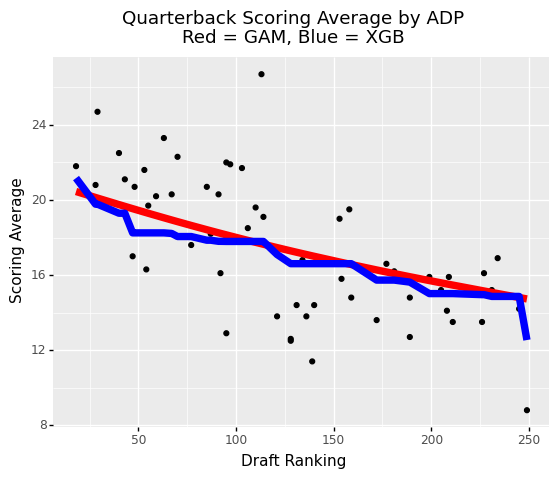

<ggplot: (108474245590)>

In [76]:
(
    ggplot(data = df_test_qb, mapping = aes(x = "rank_adp", y = "avg_scoring")) +
    geom_point() +
    geom_line(aes(y = "prediction_gam"), color = "red", size = 3) +
    geom_line(aes(y = "prediction_xgb"), color = "blue", size = 3) +
    labs(title = "Quarterback Scoring Average by ADP\nRed = GAM, Blue = XGB", 
         x = "Draft Ranking", y = "Scoring Average")
    + theme(title = element_text(lineheight = 1.1))
)

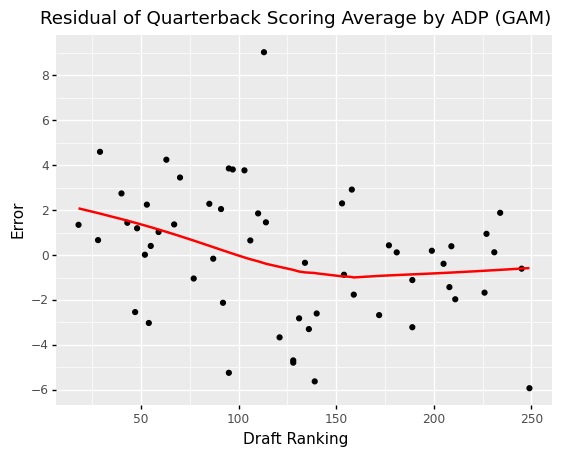

<ggplot: (108474574635)>

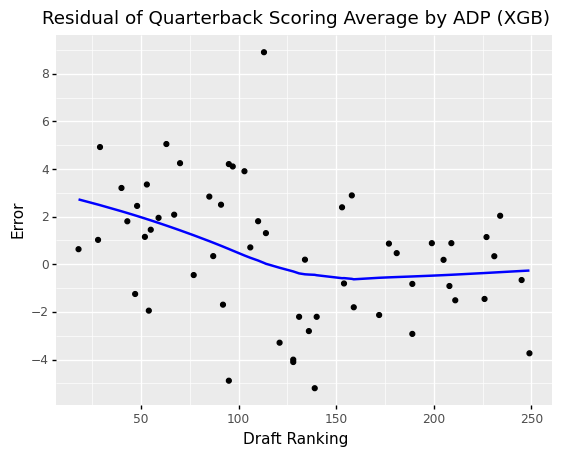

<ggplot: (108474577839)>

In [77]:
%%capture --no-display

p1 = (
    ggplot(data = df_test_qb, mapping = aes(x = "rank_adp", y = "error_gam")) +
    geom_point() +
    geom_smooth(color = "red") +
    scale_y_continuous(breaks = [i for i in range(-10, 12, 2)]) +
    labs(title = "Residual of Quarterback Scoring Average by ADP (GAM)", 
         x = "Draft Ranking", y = "Error")
)

p2 = (
    ggplot(data = df_test_qb, mapping = aes(x = "rank_adp", y = "error_xgb")) +
    geom_point() +
    geom_smooth(color = "blue") +
    scale_y_continuous(breaks = [i for i in range(-10, 12, 2)]) +
    labs(title = "Residual of Quarterback Scoring Average by ADP (XGB)", 
         x = "Draft Ranking", y = "Error")
)

display(p1, p2)

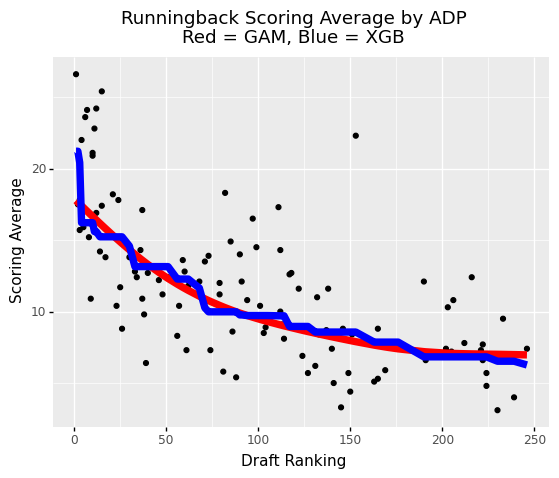

<ggplot: (108474498832)>

In [78]:
(
    ggplot(data = df_test_rb, mapping = aes(x = "rank_adp", y = "avg_scoring")) +
    geom_point() +
    geom_line(aes(y = "prediction_gam"), color = "red", size = 3) +
    geom_line(aes(y = "prediction_xgb"), color = "blue", size = 3) +
    labs(title = "Runningback Scoring Average by ADP\nRed = GAM, Blue = XGB", 
         x = "Draft Ranking", y = "Scoring Average")
    + theme(title = element_text(lineheight = 1.1))
)

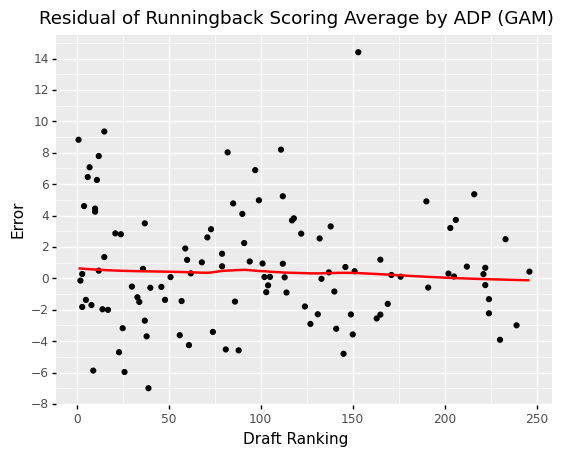

<ggplot: (108474307428)>

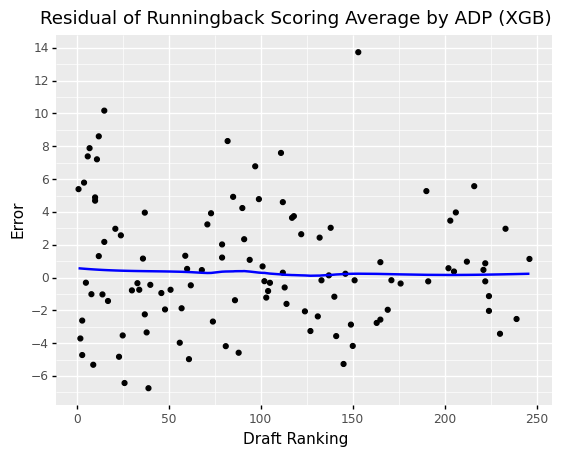

<ggplot: (108474245304)>

In [79]:
%%capture --no-display

p1 = (
    ggplot(data = df_test_rb, mapping = aes(x = "rank_adp", y = "error_gam")) +
    geom_point() +
    geom_smooth(color = "red") +
    scale_y_continuous(breaks = [i for i in range(-10, 22, 2)]) +
    labs(title = "Residual of Runningback Scoring Average by ADP (GAM)", 
         x = "Draft Ranking", y = "Error")
)

p2 = (
    ggplot(data = df_test_rb, mapping = aes(x = "rank_adp", y = "error_xgb")) +
    geom_point() +
    geom_smooth(color = "blue") +
    scale_y_continuous(breaks = [i for i in range(-10, 22, 2)]) +
    labs(title = "Residual of Runningback Scoring Average by ADP (XGB)", 
         x = "Draft Ranking", y = "Error")
)

display(p1, p2)

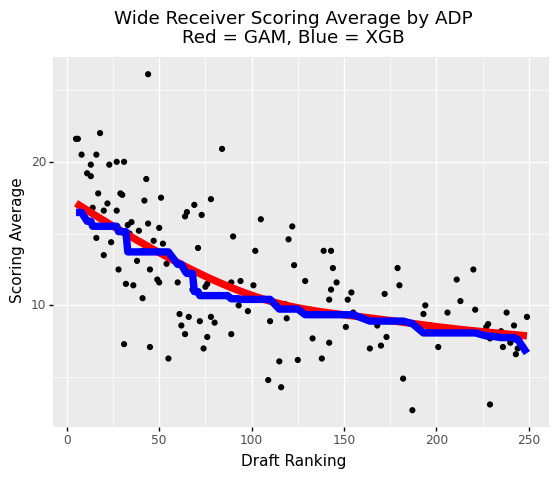

<ggplot: (108474655720)>

In [80]:
(
    ggplot(data = df_test_wr, mapping = aes(x = "rank_adp", y = "avg_scoring")) +
    geom_point() +
    geom_line(aes(y = "prediction_gam"), color = "red", size = 3) +
    geom_line(aes(y = "prediction_xgb"), color = "blue", size = 3) +
    labs(title = "Wide Receiver Scoring Average by ADP\nRed = GAM, Blue = XGB", 
         x = "Draft Ranking", y = "Scoring Average")
    + theme(title = element_text(lineheight = 1.1))
)

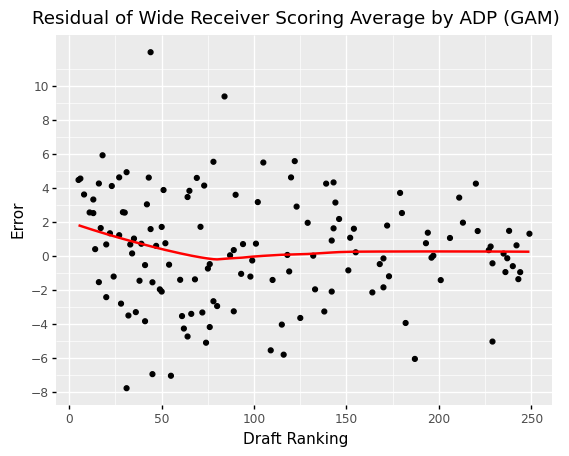

<ggplot: (108474761933)>

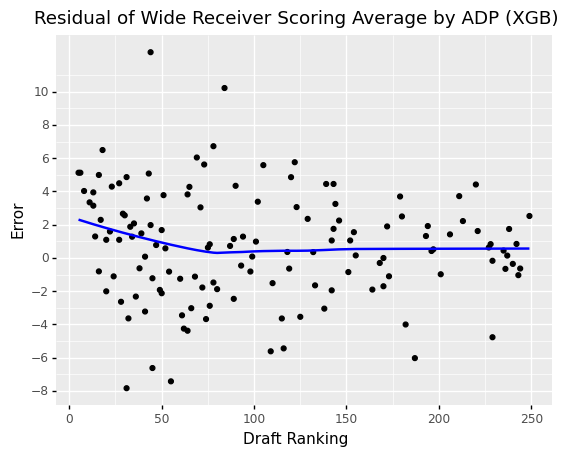

<ggplot: (108474378810)>

In [81]:
%%capture --no-display

p1 = (
    ggplot(data = df_test_wr, mapping = aes(x = "rank_adp", y = "error_gam")) +
    geom_point() +
    geom_smooth(color = "red") +
    scale_y_continuous(breaks = [i for i in range(-10, 12, 2)]) +
    labs(title = "Residual of Wide Receiver Scoring Average by ADP (GAM)", 
         x = "Draft Ranking", y = "Error")
)

p2 = (
    ggplot(data = df_test_wr, mapping = aes(x = "rank_adp", y = "error_xgb")) +
    geom_point() +
    geom_smooth(color = "blue") +
    scale_y_continuous(breaks = [i for i in range(-10, 12, 2)]) +
    labs(title = "Residual of Wide Receiver Scoring Average by ADP (XGB)", 
         x = "Draft Ranking", y = "Error")
)

display(p1, p2)

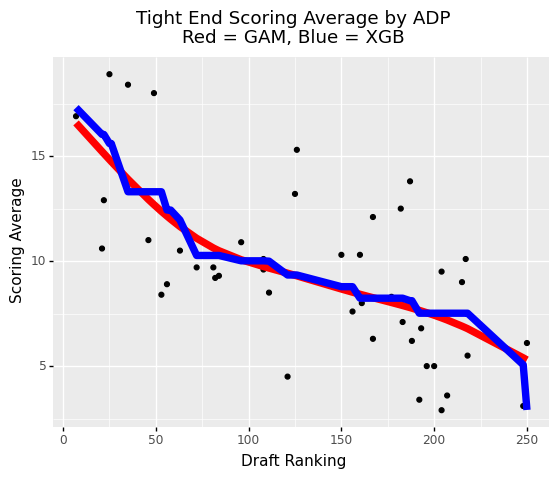

<ggplot: (108474929821)>

In [82]:
(
    ggplot(data = df_test_te, mapping = aes(x = "rank_adp", y = "avg_scoring")) +
    geom_point() +
    geom_line(aes(y = "prediction_gam"), color = "red", size = 3) +
    geom_line(aes(y = "prediction_xgb"), color = "blue", size = 3) +
    labs(title = "Tight End Scoring Average by ADP\nRed = GAM, Blue = XGB", 
         x = "Draft Ranking", y = "Scoring Average")
    + theme(title = element_text(lineheight = 1.1))
)

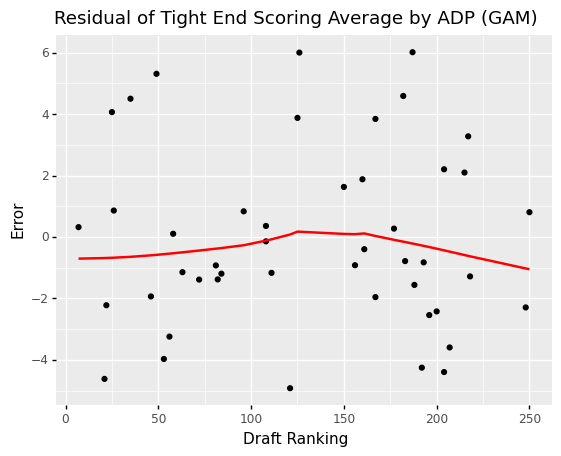

<ggplot: (108474655142)>

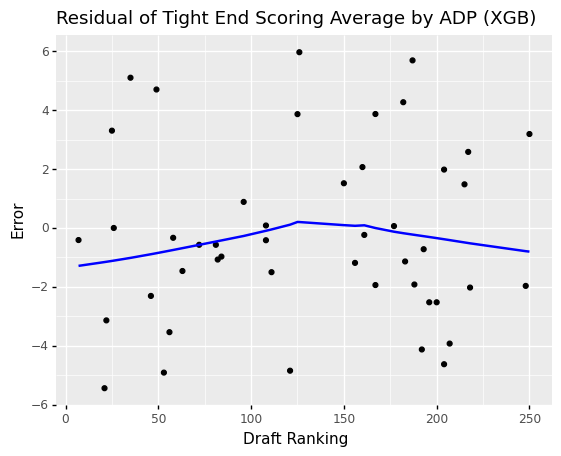

<ggplot: (108474516408)>

In [83]:
%%capture --no-display

p1 = (
    ggplot(data = df_test_te, mapping = aes(x = "rank_adp", y = "error_gam")) +
    geom_point() +
    geom_smooth(color = "red") +
    scale_y_continuous(breaks = [i for i in range(-10, 12, 2)]) +
    labs(title = "Residual of Tight End Scoring Average by ADP (GAM)", 
         x = "Draft Ranking", y = "Error")
)

p2 = (
    ggplot(data = df_test_te, mapping = aes(x = "rank_adp", y = "error_xgb")) +
    geom_point() +
    geom_smooth(color = "blue") +
    scale_y_continuous(breaks = [i for i in range(-10, 12, 2)]) +
    labs(title = "Residual of Tight End Scoring Average by ADP (XGB)", 
         x = "Draft Ranking", y = "Error")
)

display(p1, p2)

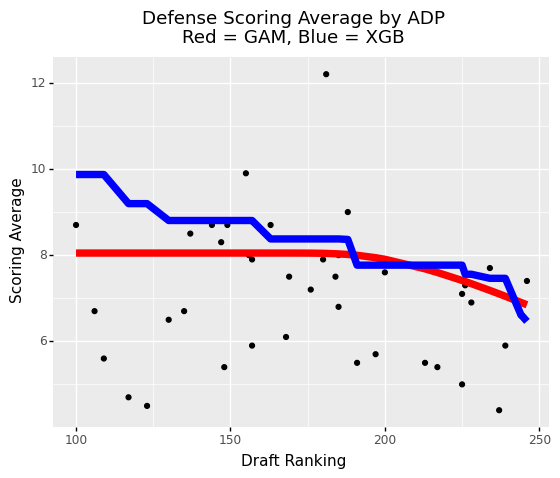

<ggplot: (108476214872)>

In [84]:
(
    ggplot(data = df_test_def, mapping = aes(x = "rank_adp", y = "avg_scoring")) +
    geom_point() +
    geom_line(aes(y = "prediction_gam"), color = "red", size = 3) +
    geom_line(aes(y = "prediction_xgb"), color = "blue", size = 3) +
    labs(title = "Defense Scoring Average by ADP\nRed = GAM, Blue = XGB", 
         x = "Draft Ranking", y = "Scoring Average")
    + theme(title = element_text(lineheight = 1.1))
)

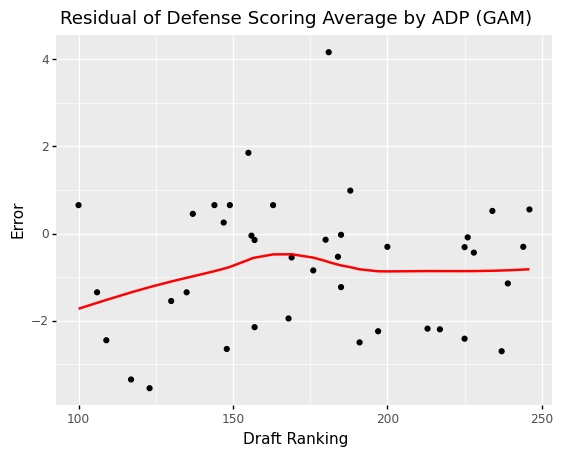

<ggplot: (108476082005)>

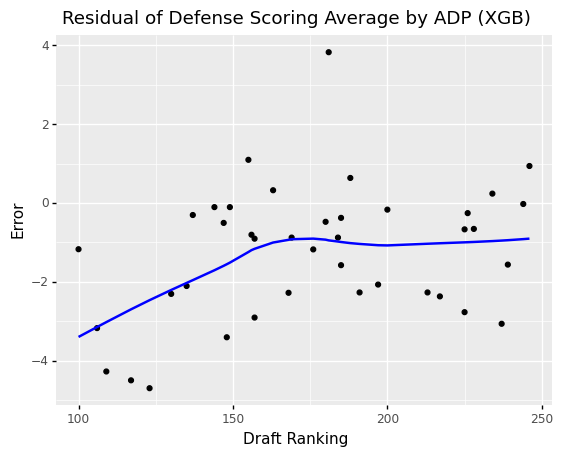

<ggplot: (108474553619)>

In [85]:
%%capture --no-display

p1 = (
    ggplot(data = df_test_def, mapping = aes(x = "rank_adp", y = "error_gam")) +
    geom_point() +
    geom_smooth(color = "red") +
    scale_y_continuous(breaks = [i for i in range(-10, 12, 2)]) +
    labs(title = "Residual of Defense Scoring Average by ADP (GAM)", 
         x = "Draft Ranking", y = "Error")
)

p2 = (
    ggplot(data = df_test_def, mapping = aes(x = "rank_adp", y = "error_xgb")) +
    geom_point() +
    geom_smooth(color = "blue") +
    scale_y_continuous(breaks = [i for i in range(-10, 12, 2)]) +
    labs(title = "Residual of Defense Scoring Average by ADP (XGB)", 
         x = "Draft Ranking", y = "Error")
)

display(p1, p2)

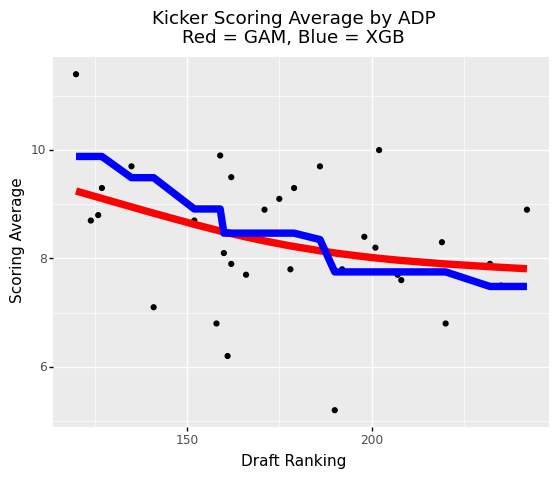

<ggplot: (108474578216)>

In [86]:
(
    ggplot(data = df_test_k, mapping = aes(x = "rank_adp", y = "avg_scoring")) +
    geom_point() +
    geom_line(aes(y = "prediction_gam"), color = "red", size = 3) +
    geom_line(aes(y = "prediction_xgb"), color = "blue", size = 3) +
    labs(title = "Kicker Scoring Average by ADP\nRed = GAM, Blue = XGB", 
         x = "Draft Ranking", y = "Scoring Average")
    + theme(title = element_text(lineheight = 1.1))
)

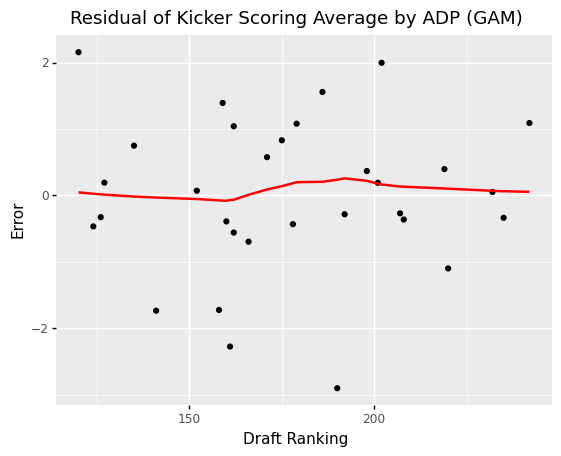

<ggplot: (108476233816)>

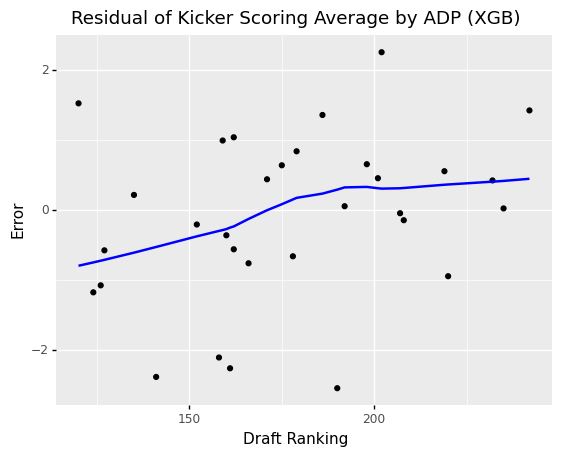

<ggplot: (108476080800)>

In [87]:
%%capture --no-display

p1 = (
    ggplot(data = df_test_k, mapping = aes(x = "rank_adp", y = "error_gam")) +
    geom_point() +
    geom_smooth(color = "red") +
    scale_y_continuous(breaks = [i for i in range(-10, 12, 2)]) +
    labs(title = "Residual of Kicker Scoring Average by ADP (GAM)", 
         x = "Draft Ranking", y = "Error")
)

p2 = (
    ggplot(data = df_test_k, mapping = aes(x = "rank_adp", y = "error_xgb")) +
    geom_point() +
    geom_smooth(color = "blue") +
    scale_y_continuous(breaks = [i for i in range(-10, 12, 2)]) +
    labs(title = "Residual of Kicker Scoring Average by ADP (XGB)", 
         x = "Draft Ranking", y = "Error")
)

display(p1, p2)

**Mean Absolute Error**

In [88]:
df_test["error_gam"].abs().mean()

2.2962264344734096

In [89]:
df_test["error_xgb"].abs().mean()

2.402575290231681

Judging from the plots and mean absolute error, 
it seems as if the GAMs are the more appropriate models. 

## Final Analysis

In [90]:
df_deriv = pd.DataFrame({"adp": np.arange(1, 251, 1)})
df_deriv

,adp
0,1
1,2
2,3
3,4
4,5
...,...
245,246
246,247
247,248
248,249


In [91]:
X_test = df_test.loc[df_test["pos"] == "QB", "rank_adp"].to_numpy()

deriv = pd.DataFrame({"adp": np.arange(min(X_test), max(X_test), 1), 
                      "qb": np.diff(gam_qb.predict(np.arange(min(X_test) - 1, max(X_test), 1)))})

df_deriv = pd.merge(df_deriv, deriv, how='left', on = ["adp"])
df_deriv.sample(5)

,adp,qb
73,74,-0.028963
59,60,-0.029980
113,114,-0.025682
246,247,-0.019269
124,125,-0.024862


In [92]:
X_test = df_test.loc[df_test["pos"] == "RB", "rank_adp"].to_numpy()

deriv = pd.DataFrame({"adp": np.arange(min(X_test), max(X_test), 1), 
                      "rb": np.diff(gam_rb.predict(np.arange(min(X_test) - 1, max(X_test), 1)))})

df_deriv = pd.merge(df_deriv, deriv, how='left', on = ["adp"])
df_deriv.sample(5)

,adp,qb,rb
236,237,-0.019327,-0.002490
180,181,-0.021208,-0.015190
101,102,-0.026561,-0.036877
6,7,NaN,-0.123874
188,189,-0.020744,-0.011624


In [93]:
X_test = df_test.loc[df_test["pos"] == "WR", "rank_adp"].to_numpy()

deriv = pd.DataFrame({"adp": np.arange(min(X_test), max(X_test), 1), 
                      "wr": np.diff(gam_wr.predict(np.arange(min(X_test) - 1, max(X_test), 1)))})

df_deriv = pd.merge(df_deriv, deriv, how='left', on = ["adp"])
df_deriv.sample(5)

,adp,qb,rb,wr
206,207,-0.019981,-0.004432,-0.014861
202,203,-0.020122,-0.005865,-0.015492
96,97,-0.026965,-0.039510,-0.047276
27,28,-0.031757,-0.110633,-0.076399
164,165,-0.022240,-0.022000,-0.015967


In [94]:
X_test = df_test.loc[df_test["pos"] == "TE", "rank_adp"].to_numpy()

deriv = pd.DataFrame({"adp": np.arange(min(X_test), max(X_test), 1), 
                      "te": np.diff(gam_te.predict(np.arange(min(X_test) - 1, max(X_test), 1)))})

df_deriv = pd.merge(df_deriv, deriv, how='left', on = ["adp"])
df_deriv.sample(5)

,adp,qb,rb,wr,te
92,93,-0.027305,-0.042157,-0.049892,-0.033265
6,7,NaN,-0.123874,-0.081798,-0.097629
155,156,-0.022764,-0.024887,-0.015506,-0.024739
32,33,-0.031611,-0.105317,-0.074819,-0.092569
139,140,-0.023700,-0.027041,-0.018074,-0.026483


In [95]:
X_test = df_test.loc[df_test["pos"] == "DST", "rank_adp"].to_numpy()

deriv = pd.DataFrame({"adp": np.arange(min(X_test), max(X_test), 1), 
                      "def": np.diff(gam_def.predict(np.arange(min(X_test) - 1, max(X_test), 1)))})

df_deriv = pd.merge(df_deriv, deriv, how='left', on = ["adp"])
df_deriv.sample(5)

,adp,qb,rb,wr,te,def
65,66,-0.029570,-0.066554,-0.065207,-0.064454,NaN
178,179,-0.021334,-0.016093,-0.017342,-0.023468,-1.247356e-03
243,244,-0.019278,-0.002769,-0.011847,-0.049315,-2.831843e-02
115,116,-0.025544,-0.032041,-0.032604,-0.024332,1.249827e-10
55,56,-0.030248,-0.077070,-0.069000,-0.075089,NaN


In [96]:
X_test = df_test.loc[df_test["pos"] == "K", "rank_adp"].to_numpy()

deriv = pd.DataFrame({"adp": np.arange(min(X_test), max(X_test), 1), 
                      "k": np.diff(gam_k.predict(np.arange(min(X_test) - 1, max(X_test), 1)))})

df_deriv = pd.merge(df_deriv, deriv, how='left', on = ["adp"])
df_deriv.sample(5)

,adp,qb,rb,wr,te,def,k
127,128,-0.024611,-0.029246,-0.023682,-0.025615,1.010498e-10,-0.019558
54,55,-0.030316,-0.078205,-0.069310,-0.076056,NaN,NaN
177,178,-0.021397,-0.016545,-0.017256,-0.023322,-9.988049e-04,-0.012359
87,88,-0.027753,-0.046130,-0.052875,-0.038176,NaN,NaN
234,235,-0.019349,-0.002377,-0.012106,-0.047410,-2.690765e-02,-0.003811


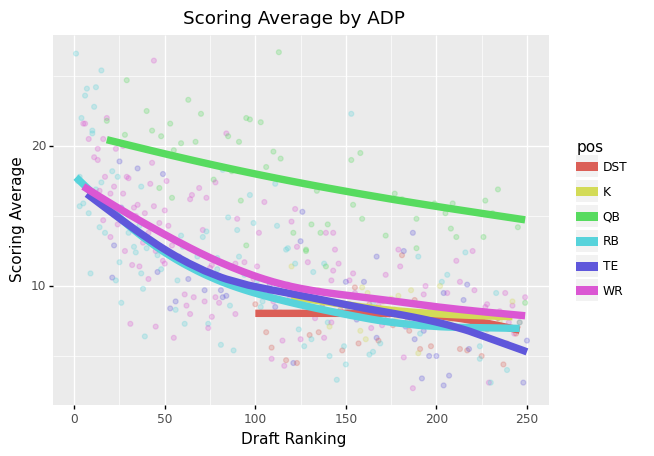

<ggplot: (108476398327)>

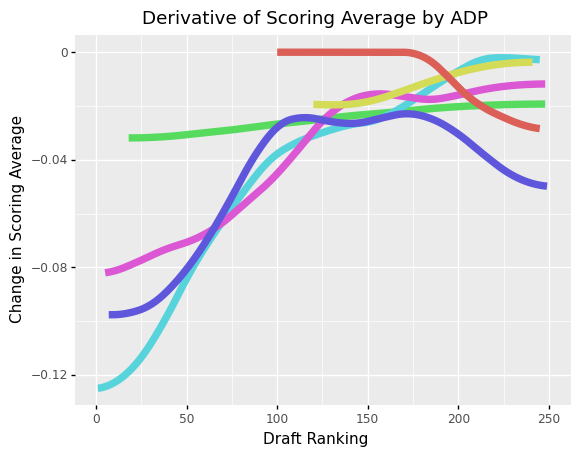

<ggplot: (108476404215)>

In [97]:
%%capture --no-display

p1 = (
    ggplot(data = df_test, mapping = aes(x = "rank_adp", y = "avg_scoring", color = "pos")) +
    geom_point(alpha = 0.25) +
    geom_line(aes(y = "prediction_gam"), size = 3) +
    labs(title = "Scoring Average by ADP", 
         x = "Draft Ranking", y = "Scoring Average")
)

p2 = (
    ggplot(data = df_deriv, mapping = aes(x = "adp")) +
    geom_line(aes(y = "qb"), color = "#57db5f", size = 3) + # lime
    geom_line(aes(y = "rb"), color = "#57d3db", size = 3) + # light blue
    geom_line(aes(y = "wr"), color = "#db57d3", size = 3) + # light purple
    geom_line(aes(y = "te"), color = "#5f57db", size = 3) + # dark blue
    geom_line(aes(y = "k"), color = "#d3db57", size = 3) + # dark yellow
    geom_line(aes(y = "def"), color = "#db5f57", size = 3) + # dark red
    labs(title = "Derivative of Scoring Average by ADP", 
         x = "Draft Ranking", y = "Change in Scoring Average")
)

display(p1, p2)

**Positional Value Function**

In [98]:
def pos_value(now, later):
    dst_now = gam_def.predict(now)[0]
    dst_later = gam_def.predict(later)[0]
    dst = dst_now - dst_later
    
    k_now = gam_k.predict(now)[0]
    k_later = gam_k.predict(later)[0]
    k = k_now - k_later
    
    qb_now = gam_qb.predict(now)[0]
    qb_later = gam_qb.predict(later)[0]
    qb = qb_now - qb_later
    
    rb_now = gam_rb.predict(now)[0]
    rb_later = gam_rb.predict(later)[0]
    rb = rb_now - rb_later
    
    wr_now = gam_wr.predict(now)[0]
    wr_later = gam_wr.predict(later)[0]
    wr = wr_now - wr_later
    
    te_now = gam_te.predict(now)[0]
    te_later = gam_te.predict(later)[0]
    te = te_now - te_later
    
    value = pd.DataFrame({"position": ["DST", "K", "QB", "RB", "TE", "WR"], 
                          "ep_now": [dst_now, k_now, qb_now, rb_now, te_now, wr_now], 
                          "ep_later": [dst_later, k_later, qb_later, rb_later, te_later, wr_later], 
                          "value": [dst, k, qb, rb, te, wr]})
    
    value["ep_now"] = value["ep_now"].astype("float64")
    value["ep_later"] = value["ep_later"].astype("float64")
    value["value"] = value["value"].astype("float64")
    
    value.sort_values("value", ascending = False, ignore_index = True, inplace = True)
    value = value.round(2)
    
    return value

In [99]:
pos_value(155, 165)

,position,ep_now,ep_later,value
0,TE,8.54,8.30,0.24
1,RB,7.84,7.61,0.24
2,QB,16.65,16.43,0.23
3,K,8.58,8.41,0.16
4,WR,9.27,9.11,0.16
5,DST,8.05,8.05,-0.00


# Conclusion

**Model Suggestions**
- Select runningbacks early. 
- Target wide receivers around pick 100. 
- Wait to pick defenses. 

**Further Improvements**

In fantasy football, you can only "start" a certain amount of players of each position. 
A future project could account for the value decrease if the fantasy owner has 
already drafted players of the same position. 